In [3]:
import sys
sys.path.append("../") # go to parent dir

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
from tqdm import tqdm
key = jax.random.PRNGKey(5)

In [19]:
gridsizes = jnp.array([10,15,20])
Ns = jnp.arange(1, 10)
maxss = []
meanss = []
errss = []

In [10]:
for gridsize in gridsizes:
    solver = chb.Solver(N = gridsize)
    xx = solver.xx
    yy = solver.yy
    grid = solver.grid
    dims = (solver.N, solver.N)
    mask = np.ones(dims)
    mask[1:-1,1:-1] = 0
    maskx = np.ones(dims)
    maskx[:,1:-1] = 0
    masky = np.ones(dims)
    masky[1:-1,:] = 0
    mask = jnp.array(mask)
    ii, jj = jnp.meshgrid(jnp.arange(solver.N), jnp.arange(solver.N))
    a = 1.4
    index_decay = jnp.exp(-(ii+jj)/a)

    k_cheby_init = jax.random.normal(key, shape = dims) * index_decay
    k_cheby_init = k_cheby_init.at[0,0].set(k_cheby_init[0,0] + jnp.sum(index_decay)*2)
    k_cheby_init = k_cheby_init.flatten()
    k_init = (solver.I @ k_cheby_init).reshape(dims)

    maxs = []
    means = []

    key = jax.random.PRNGKey(5)
    for N in Ns:
        N_measure = N
        measurements = []
        for i in range(N_measure):
            key, _ = jax.random.split(key)

            dirichlet_cheby = jax.random.normal(key, shape = dims) * index_decay
            dirichlet = (solver.I @ dirichlet_cheby.flatten()).reshape(dims)
            dirichlet *= mask

            sol = solver.solve(k_cheby_init, dirichlet)

            measurements.append((dirichlet, sol))

        @jax.jit
        def get_neumann(solution):
            jx = (solution["dx T"] * solution["k"]).reshape(dims)
            jy = (solution["dy T"] * solution["k"]).reshape(dims)

            neumann = jnp.concatenate((jx[:,0], jy[-1,:], jx[:,-1], jy[0,:]), axis = 0)
            return neumann

        @jax.jit
        def distance(solution, target_solution):
            neumann = get_neumann(solution)
            target_neumann = get_neumann(target_solution)

            return jnp.sum((neumann - target_neumann)**2)

        @jax.jit
        def get_solution(k_param, dirichlet):
            k_cheby = k_param["coeff"] * index_decay
            k_cheby = k_cheby.flatten()
            solution = solver.solve(k_cheby, dirichlet)
            return solution


        @jax.jit
        def get_solution_internal(k_cheby_flat, dirichlet):
            solution = solver.solve(k_cheby_flat, dirichlet)
            return solution
        ## 3. Optimize parameters
        @jax.jit
        def loss(k_param):
            acc = 0
            for i in range(N_measure):
                acc += distance(get_solution(k_param, measurements[i][0]), measurements[i][1])
            return acc

        @jax.jit
        def loss_internal(k_cheby_flat):
            acc = 0
            for i in range(N_measure):
                acc += distance(get_solution_internal(k_cheby_flat, measurements[i][0]), measurements[i][1])
            return acc


        ## 2. Initialise variational parameters
        key, _ = jax.random.split(key)
        k_cheby = jax.random.normal(key, shape = dims) * index_decay
        k_cheby = k_cheby.at[0,0].set(k_cheby[0,0] + jnp.sum(index_decay))

        k_param = {"coeff":k_cheby}


        g = jax.value_and_grad(loss)
        h = jax.hessian(loss_internal)
        # define
        optimizer = optax.sgd(learning_rate=0.0003)

        # initialise
        optimizer_state = optimizer.init(k_param)

        err = []
        for i in tqdm(range(1200)):
            val, grad = g(k_param)
            err.append(val)

            updates, optimizer_state = optimizer.update(grad, optimizer_state, k_param)

            k_param = optax.apply_updates(k_param, updates)
        # plt.plot(err)
        # plt.yscale("log")
        result = get_solution(k_param, measurements[0][0])
        max = jnp.max(jnp.abs(result["k"].reshape(dims) / (measurements[0][1]["k"].reshape(dims)) - 1))
        maxs.append(np.array(max))
        mean = jnp.mean(jnp.abs(result["k"].reshape(dims) / (measurements[0][1]["k"].reshape(dims)) - 1))
        means.append(np.array(mean))

    maxss.append(maxs)
    meanss.append(means)
    errss.append(err)


  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:07<00:00, 157.09it/s]


Text(0, 0.5, 'Mean Relative Error')

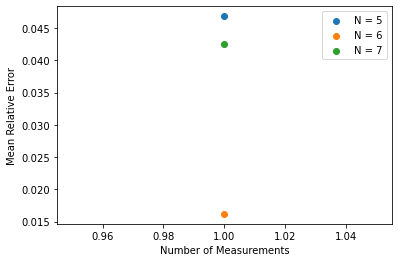

In [17]:
plt.scatter(Ns, meanss[0], label = "N = "+str(gridsizes[0]))
plt.scatter(Ns, meanss[1], label = "N = "+str(gridsizes[1]))
plt.scatter(Ns, meanss[2], label = "N = "+str(gridsizes[2]))
plt.legend()
plt.xlabel("Number of Measurements")
plt.ylabel("Mean Relative Error")